In [1]:
import sys

sys.path.append("..")

import pickle as pkl

import jax
import jax.numpy as jnp
import numpy as np
import optax
import plotly.express as px
from cbdetect_py import CornerType, Params, boards_from_corners, find_corners
from ipywidgets import FloatSlider, IntRangeSlider, interact
from jaxopt import GradientDescent
from pandas.compat import os
from PIL import Image

from calibration.benchmark.benchmark import (
    BenchmarkResult,
    benchmark_babelcalib,
    benchmark_simul,
)
from calibration.data.babelcalib.babelcalib import load_babelcalib
from calibration.data.babelcalib.entry import Entry
from calibration.feature_detector.checkerboard import detect_corners
from calibration.feature_detector.visualization import show_boards, show_corners
from calibration.projector.camera import Camera
from calibration.projector.projector import Projector

# %load_ext autoreload
# %autoreload 2

In [2]:
key = "OV/cube/ov00", "train", "ov00/0031.pgm"
with open("../babelcalib_results.pkl", "rb") as f:
    r: BenchmarkResult = next(
        r
        for r in pkl.load(f)
        if (r.input.ds_name, r.input.subds_name, r.input.name) == key
    )
    assert isinstance(r.input, Entry)
    assert r.input.image is not None
    assert r.features is not None

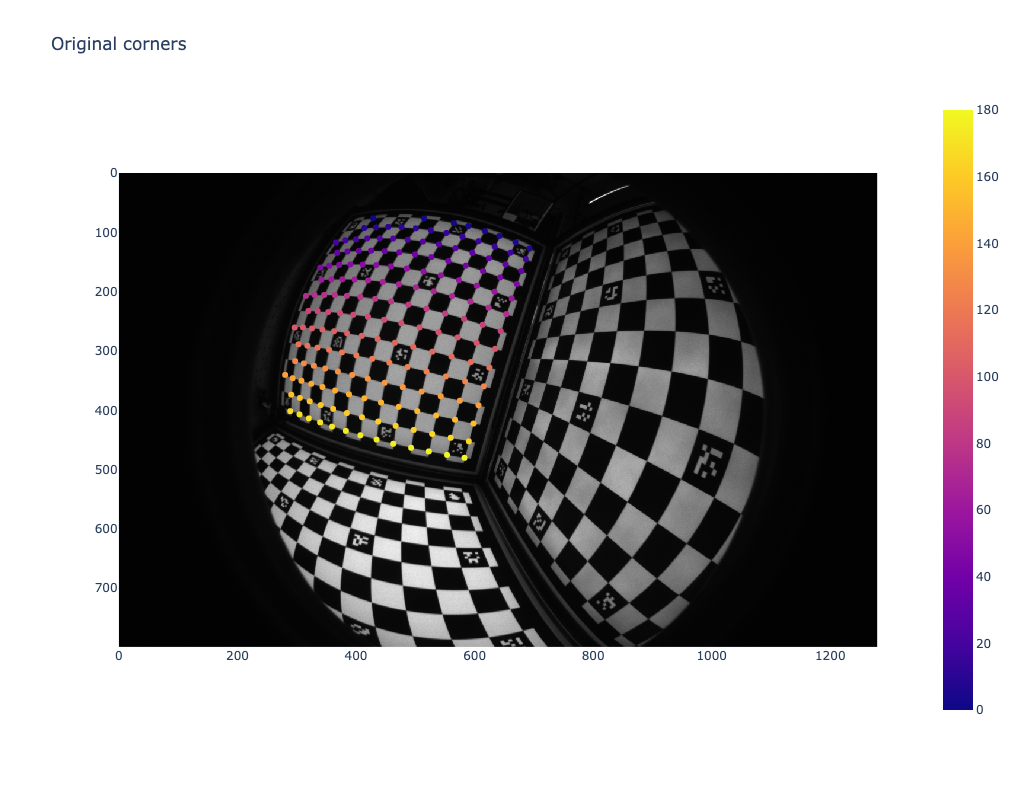

In [3]:
w, h = r.input.image.size

show_boards(
    np.array(r.input.image), r.features.corners, r.features.board
).update_layout(height=h, width=w, title="Original corners")

In [4]:
@jax.jit
def backproject(
    x: jnp.array,
    R: jnp.array,
    t: jnp.array,
    lambdas: jnp.array,
    intrinsic_matrix: jnp.array,
) -> jnp.ndarray:
    """
    Simulates the backprojection of image points (x) onto a board plane,
    given the simulation parameters (p).

    Args:

    x (np.ndarray):
        An array of point in the image space, with shape (n, 2),
        where n is the number of points and each point is represented as [x, y].

    Returns:
        X (np.ndarray):
            An array of point in the board space, with shape (n, 2),
            where n is the number of points and each point is represented as [x, y].
    """
    # Intrinsics
    x1 = jnp.c_[x, jnp.ones(x.shape[0])]
    x2 = (jnp.linalg.inv(intrinsic_matrix) @ x1.T).T
    # Pyright bug
    x3 = x2 / x2[:, 2][:, None]

    # Distortion
    x4 = x3.at[:, 2].set(psi(lambdas, jnp.linalg.norm(x3[:, :2], axis=1)))
    x5 = x4 / x4[:, 2][:, None]

    # Extrinsics
    P = jnp.c_[R[:, :2], t]
    x6 = (jnp.linalg.inv(P) @ x5.T).T
    x7 = x6 / x6[:, 2][:, None]
    return x7[:, :2]


@jax.jit
def psi(lambdas: jnp.array, r: jnp.array) -> jnp.array:
    l1, l2 = lambdas
    return 1 + l1 * r**2 + l2 * r**4

In [5]:
corners = jnp.array(r.features.corners)
board = jnp.array(r.features.board)
R = jnp.array(r.prediction.R)
t = jnp.array(r.prediction.t)
lambdas = jnp.array(r.prediction.lambdas)
camera_matrix = jnp.array(r.prediction.camera.intrinsic_matrix)

board_ = backproject(corners, R, t, lambdas, camera_matrix)
np.testing.assert_allclose(
    board_, r.prediction.backproject(r.features.corners), rtol=1e-3
)

In [6]:
@jax.jit
def rotation_matrix_to_euler_angles(R):
    sy = jnp.sqrt(R[0, 0] * R[0, 0] + R[1, 0] * R[1, 0])

    @jax.jit
    def f1(sy):
        x = jnp.arctan2(R[2, 1], R[2, 2])
        y = jnp.arctan2(-R[2, 0], sy)
        z = jnp.arctan2(R[1, 0], R[0, 0])
        return jnp.array([x, y, z])

    @jax.jit
    def f2(sy):
        x = jnp.arctan2(-R[1, 2], R[1, 1])
        y = jnp.arctan2(-R[2, 0], sy)
        z = 0
        return jnp.array([x, y, z])

    return jax.lax.cond(sy < 1e-6, f2, f1, operand=sy)


@jax.jit
def euler_angles_to_rotation_matrix(theta):
    R_x = jnp.array(
        [
            [1, 0, 0],
            [0, jnp.cos(theta[0]), -jnp.sin(theta[0])],
            [0, jnp.sin(theta[0]), jnp.cos(theta[0])],
        ]
    )

    R_y = jnp.array(
        [
            [jnp.cos(theta[1]), 0, jnp.sin(theta[1])],
            [0, 1, 0],
            [-jnp.sin(theta[1]), 0, jnp.cos(theta[1])],
        ]
    )

    R_z = jnp.array(
        [
            [jnp.cos(theta[2]), -jnp.sin(theta[2]), 0],
            [jnp.sin(theta[2]), jnp.cos(theta[2]), 0],
            [0, 0, 1],
        ]
    )

    R = jnp.dot(R_z, jnp.dot(R_y, R_x))

    return R

In [28]:
def loss(params, fixed_params):
    corners = fixed_params["corners"]
    board = fixed_params["board"]
    R = euler_angles_to_rotation_matrix(params["theta"])
    t = params["t"]
    lambdas = params["lambdas"]

    pixel_size = params["sensor_size"] / fixed_params["resolution"]
    fx, fy = params["focal_length"] / pixel_size
    cx, cy = fixed_params["resolution"] / 2
    intrinsic_matrix = jnp.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

    board_ = backproject(corners, R, t, lambdas, intrinsic_matrix)
    return jnp.mean(jnp.square(board_ - board))

In [29]:
def optimize_optax(loss, params, fixed_params, step_size=0.001, num_steps=1000):
    # Create an Adam optimizer
    optimizer = optax.adam(step_size)

    # Initialize the optimizer state.
    opt_state = optimizer.init(params)

    # Define a function to compute the gradient and update the parameters
    @jax.jit
    def step(params, opt_state):
        loss_value, grads = jax.value_and_grad(loss)(params, fixed_params)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value

    #     loss_value, grads = jax.value_and_grad(loss)(params, batch, labels)
    # updates, opt_state = optimizer.update(grads, opt_state, params)
    # params = optax.apply_updates(params, updates)
    # return params, opt_state, loss_value

    # Run the optimization loop
    for i in range(num_steps):
        params, opt_state, loss_value = step(params, opt_state)
        if i % 10000 == 0:
            print(loss_value)

    return params

In [43]:
fixed_params = {
    "corners": jnp.array(r.features.corners),
    "board": jnp.array(r.features.board),
    # "camera_matrix": jnp.array(r.prediction.camera.intrinsic_matrix),
    "resolution": jnp.array(r.prediction.camera.resolution),
}

initial_params = {
    # "R": jnp.array(r.prediction.R),
    "theta": rotation_matrix_to_euler_angles(r.prediction.R),
    "t": jnp.array(r.prediction.t),
    "lambdas": jnp.array(r.prediction.lambdas),
    "focal_length": jnp.array(float(r.prediction.camera.focal_length)),
    "sensor_size": jnp.array(r.prediction.camera.sensor_size)
    # "focal_length_pixels": jnp.array(r.prediction.camera.focal_length_pixels),
}

key = jax.random.PRNGKey(0)
keys = jax.random.split(key, 5)  # Generate 5 separate keys for each parameter

initial_params = {
    "theta": jax.random.normal(keys[0], (3,)) * 0.01,  # small random values for three angles
    "t": jax.random.normal(keys[1], (3,)) * 0.01,  # small random values for translation vector
    "lambdas": jax.random.normal(keys[2], (2,)) * 0.01,  # small random values for lambdas
    "focal_length": jax.random.normal(keys[3], (1,)) * 0.01,  # small random value for focal length
    "sensor_size": jax.random.normal(keys[4], (2,)) * 0.01,  # small random values for sensor size
}


In [44]:
optimized_params = optimize_optax(
    loss, initial_params, fixed_params, step_size=0.001, num_steps=100000
)

49.568275
6.5398216
0.014033579
0.0141750835
0.008104423
0.0022883054
0.0009279586
0.0005306499
0.00040995952
0.00037368492


In [45]:
optimized_params["camera"] = Camera(
    focal_length=optimized_params["focal_length"],
    sensor_size=optimized_params["sensor_size"],
    resolution=fixed_params["resolution"],
)

del optimized_params["focal_length"]
del optimized_params["sensor_size"]

optimized_params["R"] = euler_angles_to_rotation_matrix(optimized_params["theta"])
del optimized_params["theta"]

In [46]:
# proj = Projector(**{k: np.array(v) for k, v in optimized_params.items()})

proj = Projector(**optimized_params)

In [50]:
proj

Projector(R=Array([[ 0.8957076 , -0.29093143,  0.33625397],
       [ 0.21388516,  0.944906  ,  0.2478017 ],
       [-0.38982174, -0.15003815,  0.9085854 ]], dtype=float32), t=Array([ -7.9802017, -12.053221 ,  -5.507679 ], dtype=float32), lambdas=Array([-0.37786615, -0.16150653], dtype=float32), camera=Camera(focal_length=Array([0.04037262], dtype=float32), sensor_size=Array([-0.14007042, -0.08681675], dtype=float32), resolution=Array([1280,  800], dtype=int32), skew=0.0))

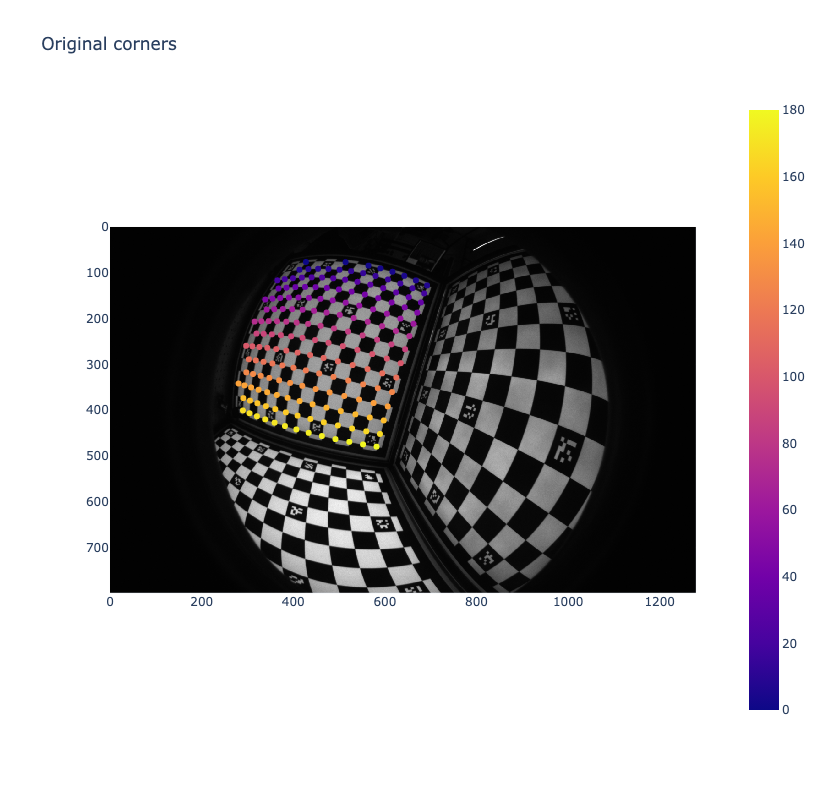

In [47]:
show_boards(
    np.array(r.input.image), proj.project(r.features.board), r.features.board
).update_layout(height=h, width=w, title="Original corners")

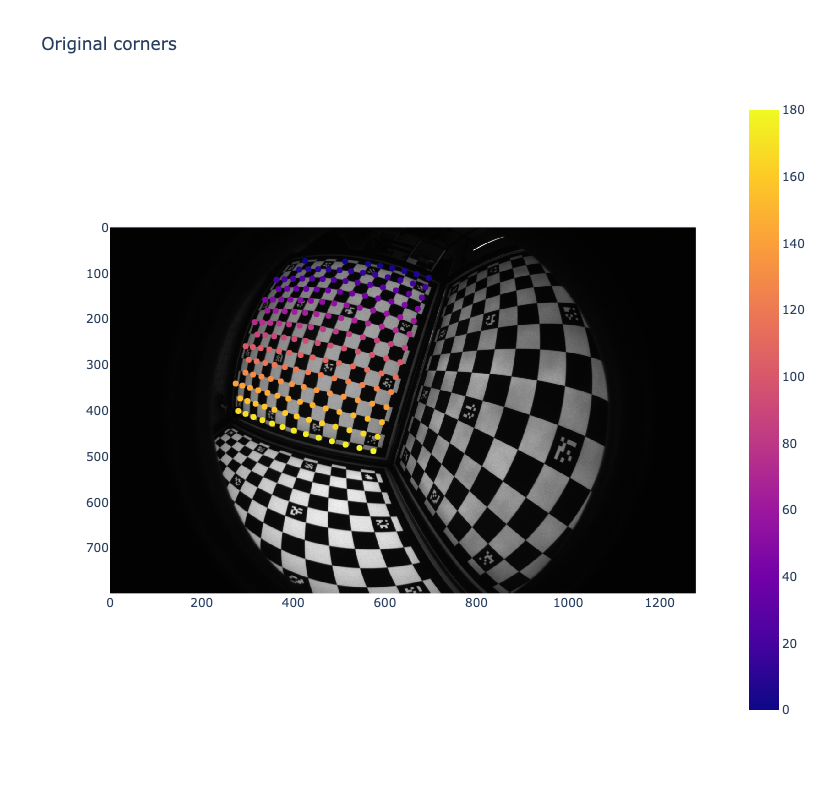

In [48]:
corners_ = proj.project(board)

show_boards(
    np.array(r.input.image), r.prediction.project(r.features.board), r.features.board
).update_layout(height=h, width=w, title="Original corners")

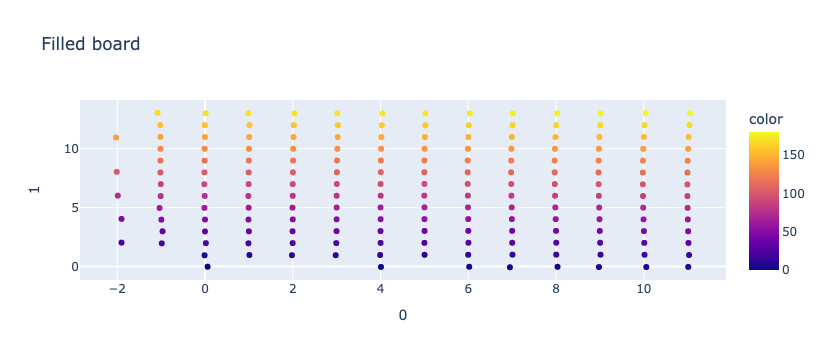

In [49]:
board_ = proj.backproject(r.features.corners)

px.scatter(board_, x=0, y=1, color=range(board_.shape[0]), title="Filled board")